In [1]:
! pip install pymc3 daft

     |████████████████████████████████| 872 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 19.7 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 3.6 MB/s  eta 0:00:01
     |████████████████████████████████| 39.3 MB 55.5 MB/s eta 0:00:01�███           | 25.7 MB 2.2 MB/s eta 0:00:07█████▌        | 28.8 MB 55.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 22.3 MB/s eta 0:00:01
     |████████████████████████████████| 870 kB 20.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 17.4 MB/s eta 0:00:01
     |████████████████████████████████| 238 kB 10.6 MB/s eta 0:00:01
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529946 sha256=7e4b50ba990e8e805d400ee198be6e7cdf32f9d2795e405436685590704d6753
  Stored in directory: /home/dusty/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc
  Attempting uninstall: scipy
    Found existing inst

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [5]:
data = pd.read_csv("/mnt/c/Users/dusty/Desktop/mariners2021.csv")

In [6]:
at_bats, hits = data[['at_bats', 'hits']].to_numpy().T

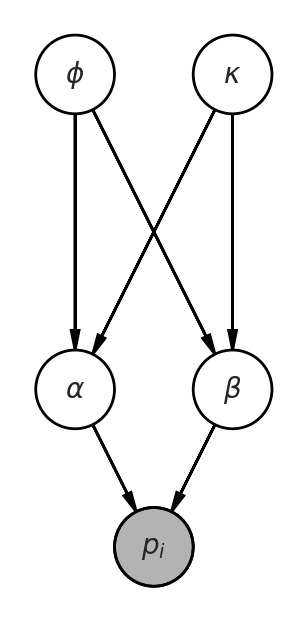

In [41]:
import daft

# Instantiate the PGM.
pgm = daft.PGM()

# Hierarchical parameters.
pgm.add_node("phi", "$\phi$", 0.5, 3)
pgm.add_node("kappa", r"$\kappa$", 1.5, 3)

pgm.add_node("alpha", r"$\alpha$", 0.5, 1)
pgm.add_node("beta", r"$\beta$", 1.5, 1)

pgm.add_node("p", r"$p_i$", 1, 0, observed=True)

# Add in the edges.
pgm.add_edge("phi", "alpha")
pgm.add_edge("phi", "beta")
pgm.add_edge("kappa", "alpha")
pgm.add_edge("kappa", "beta")
pgm.add_edge("alpha", "p")
pgm.add_edge("beta", "p")


# Render and save.
pgm.render()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta_new, thetas, kappa_log, phi]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


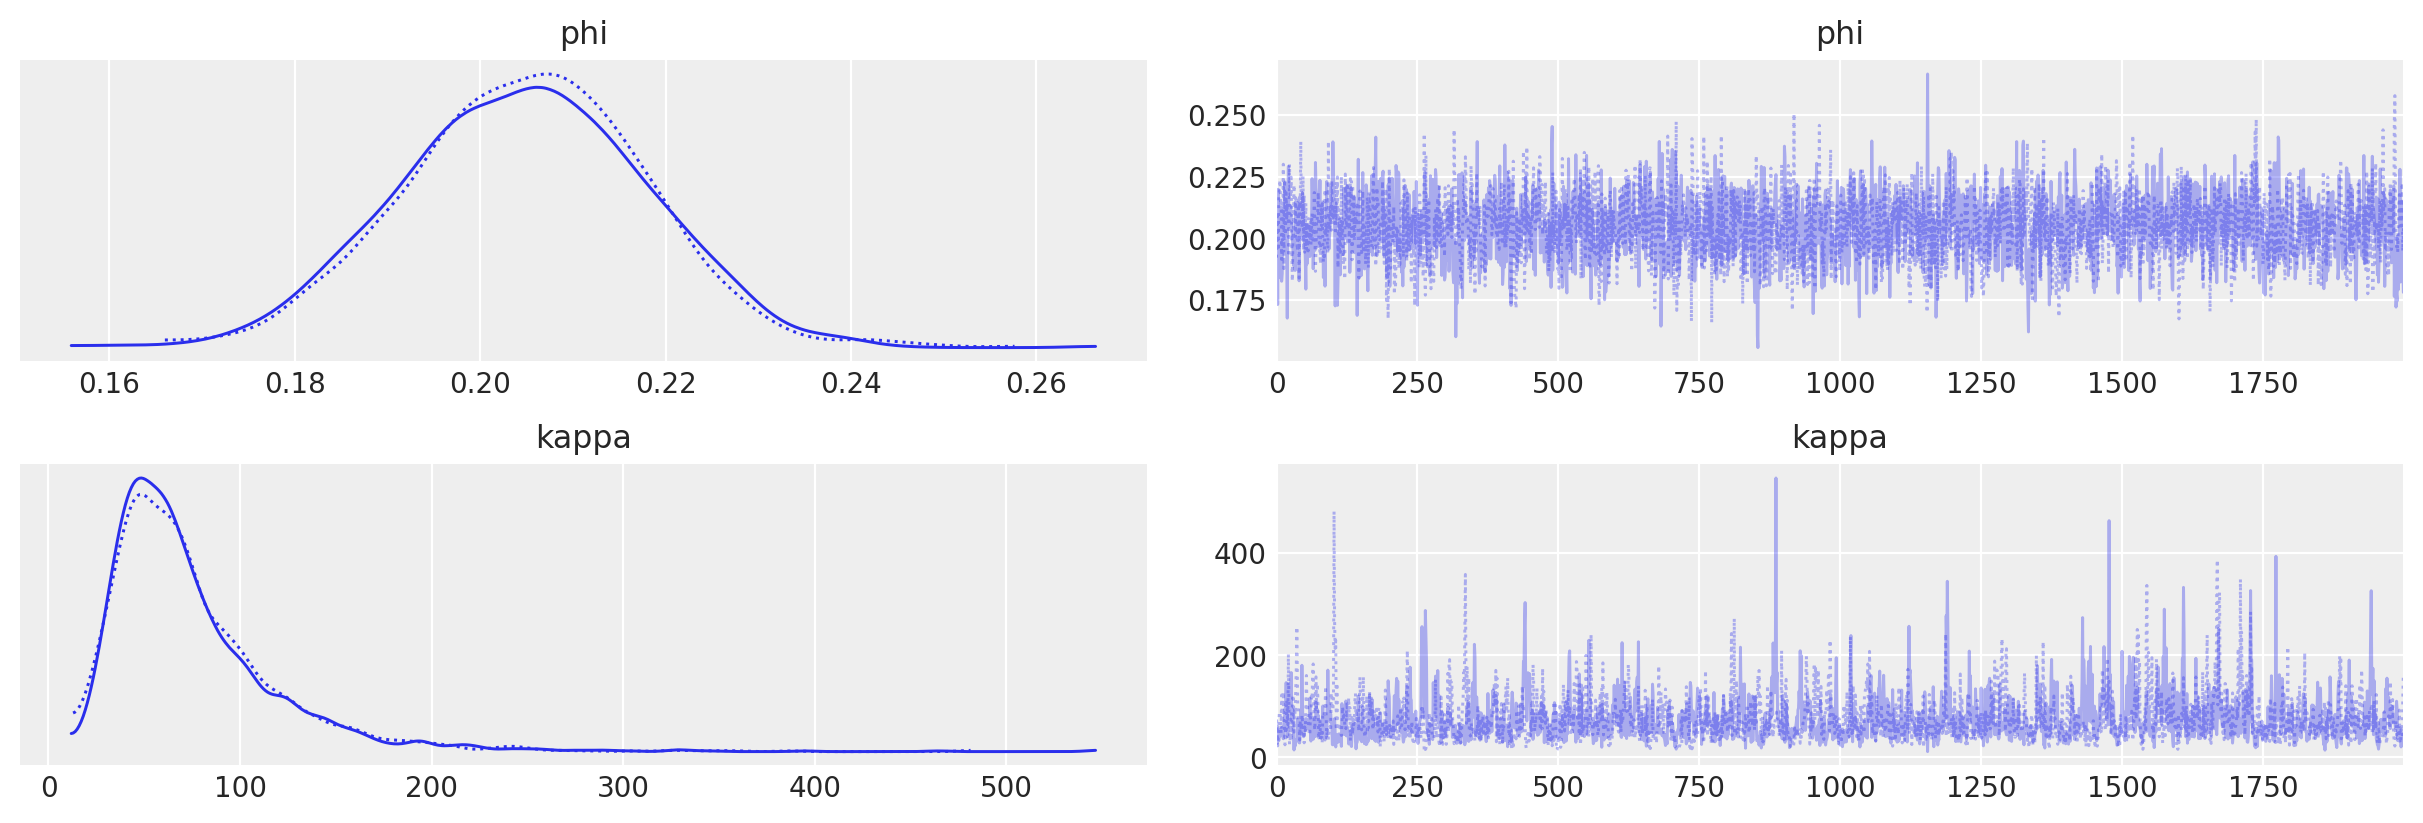

In [20]:
N = len(hits)

with pm.Model() as baseball_model:

    phi = pm.Uniform("phi", lower=0.0, upper=1.0)

    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

    thetas = pm.Beta("thetas", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=N)
    y = pm.Binomial("y", n=at_bats, p=thetas, observed=hits)
    
with baseball_model:

    theta_new = pm.Beta("theta_new", alpha=phi * kappa, beta=(1.0 - phi) * kappa)
    y_new = pm.Binomial("y_new", n=50, p=theta_new, observed=0)
    
with baseball_model:
    trace = pm.sample(2000, tune=2000, chains=2, target_accept=0.95, return_inferencedata=True)

    # check convergence diagnostics
    assert all(az.rhat(trace) < 1.03)
    
az.plot_trace(trace, var_names=["phi", "kappa"]);

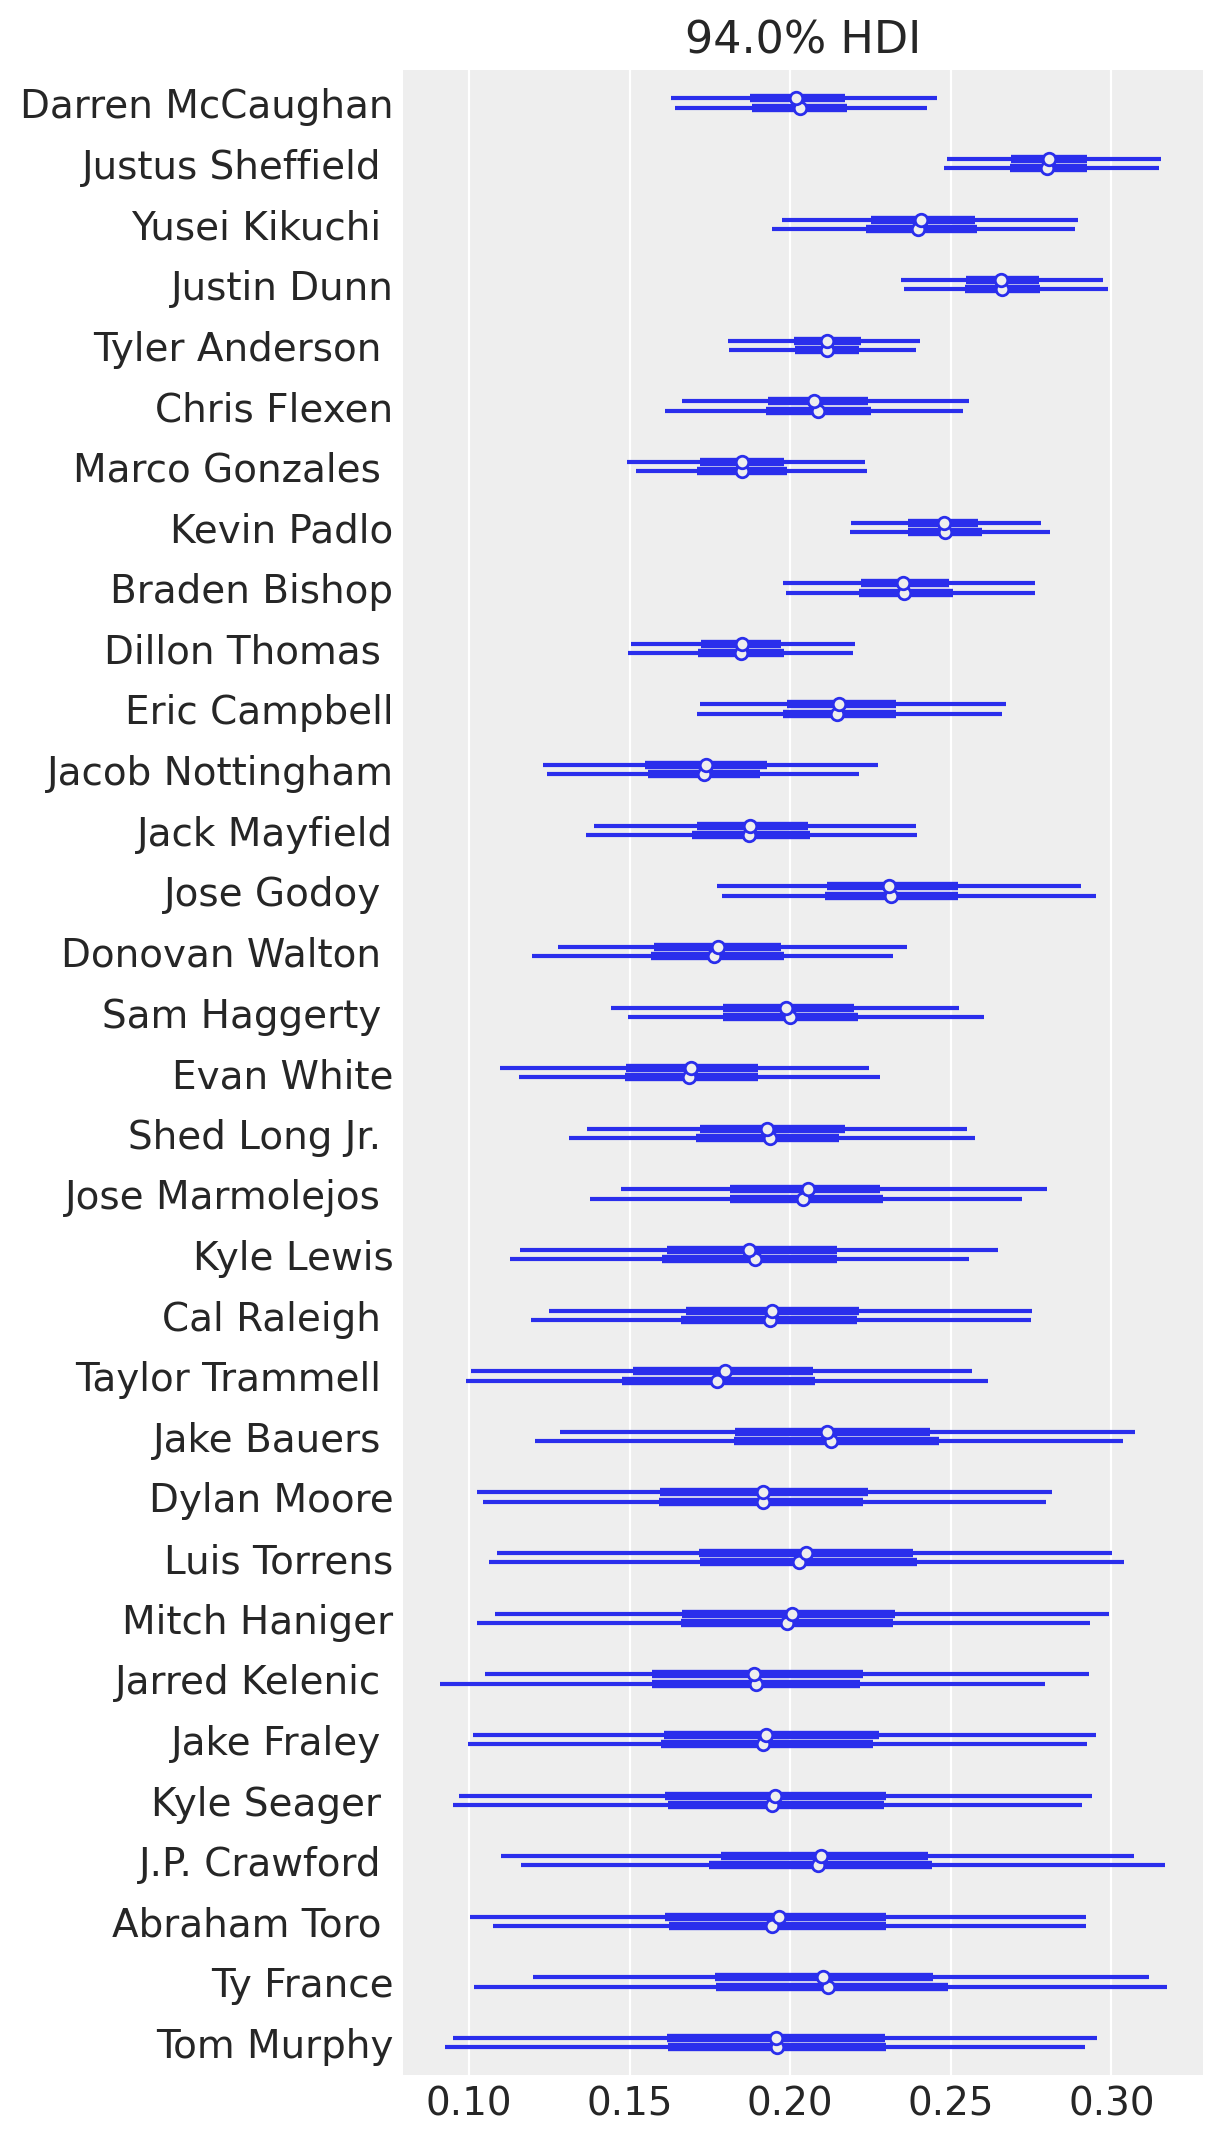

In [21]:
player_names = data['name']

ax = az.plot_forest(trace, var_names=["thetas"])
ax[0].set_yticklabels(player_names.tolist());

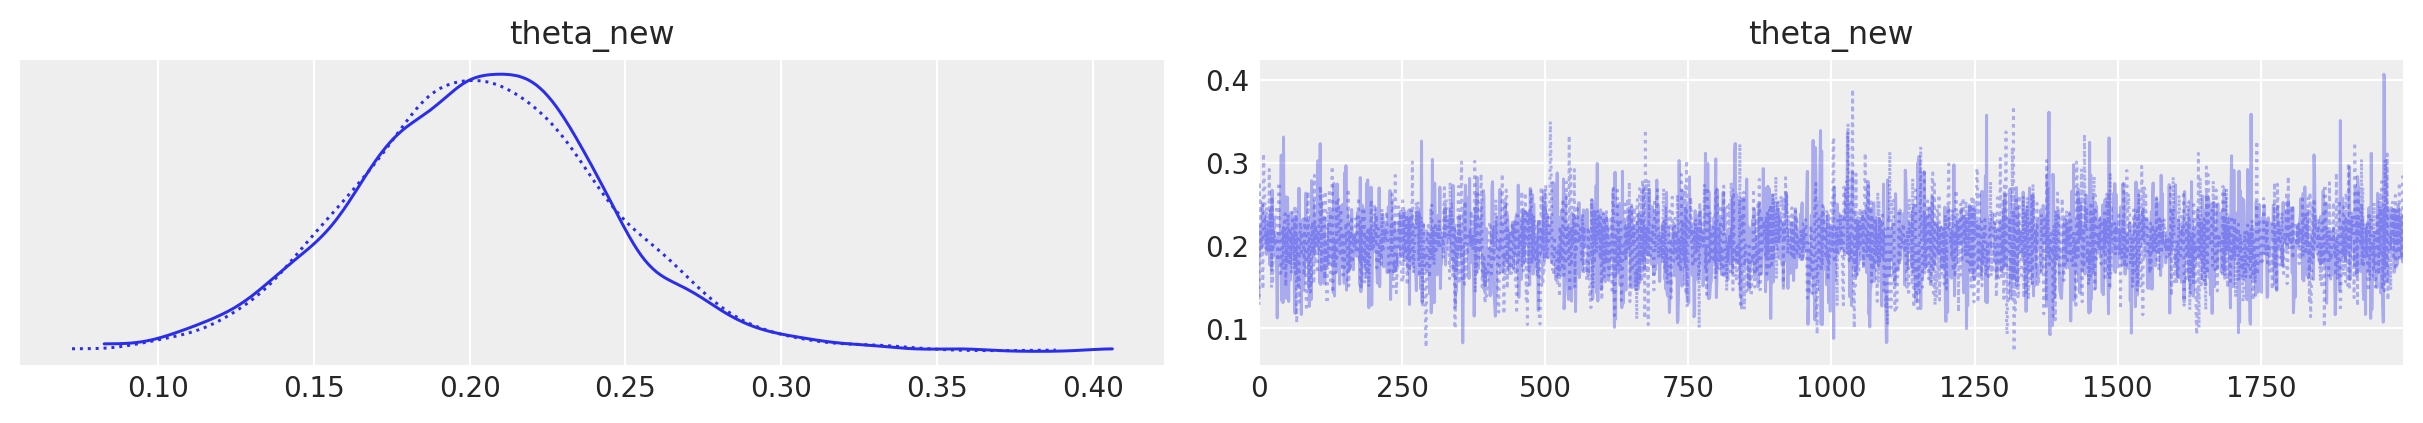

In [19]:
az.plot_trace(trace, var_names=["theta_new"]); # 4 at-bats

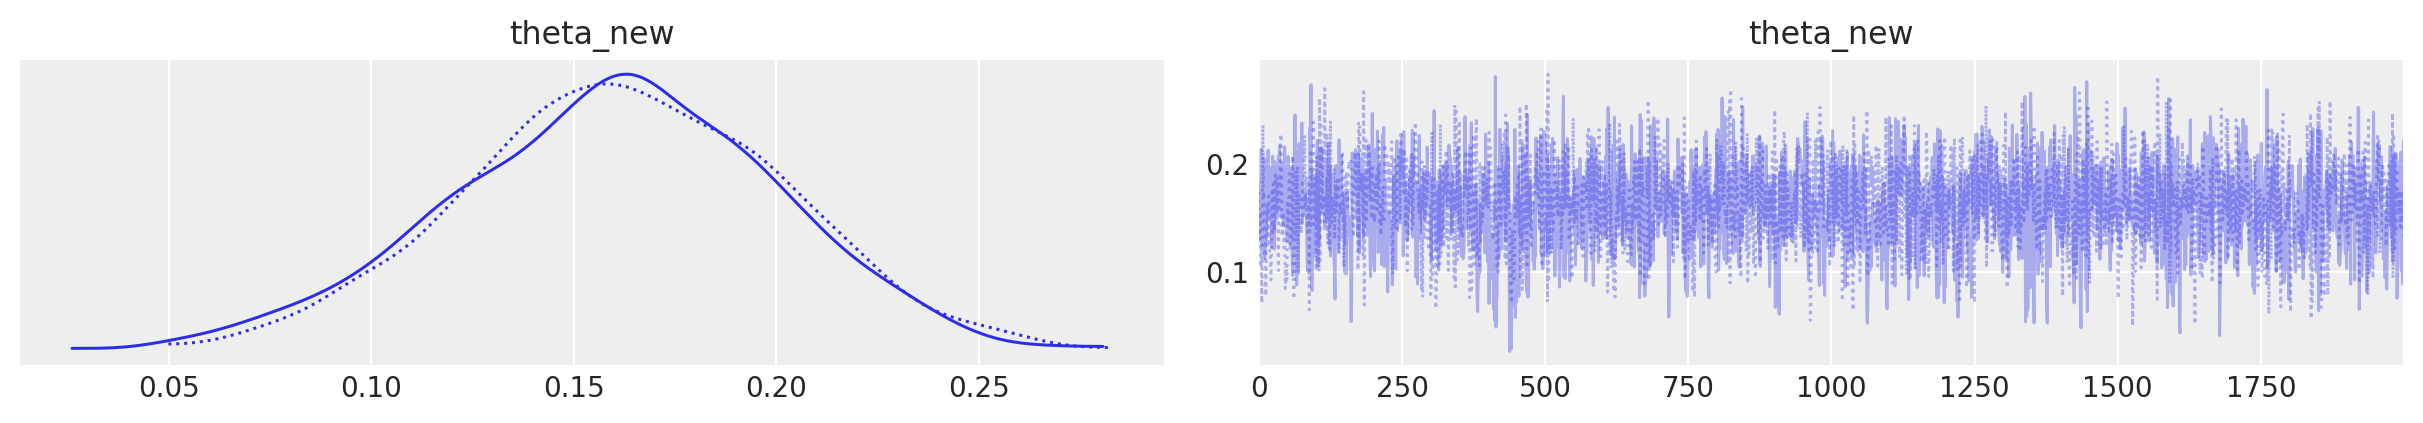

In [16]:
az.plot_trace(trace, var_names=["theta_new"]); # 25 at-bats

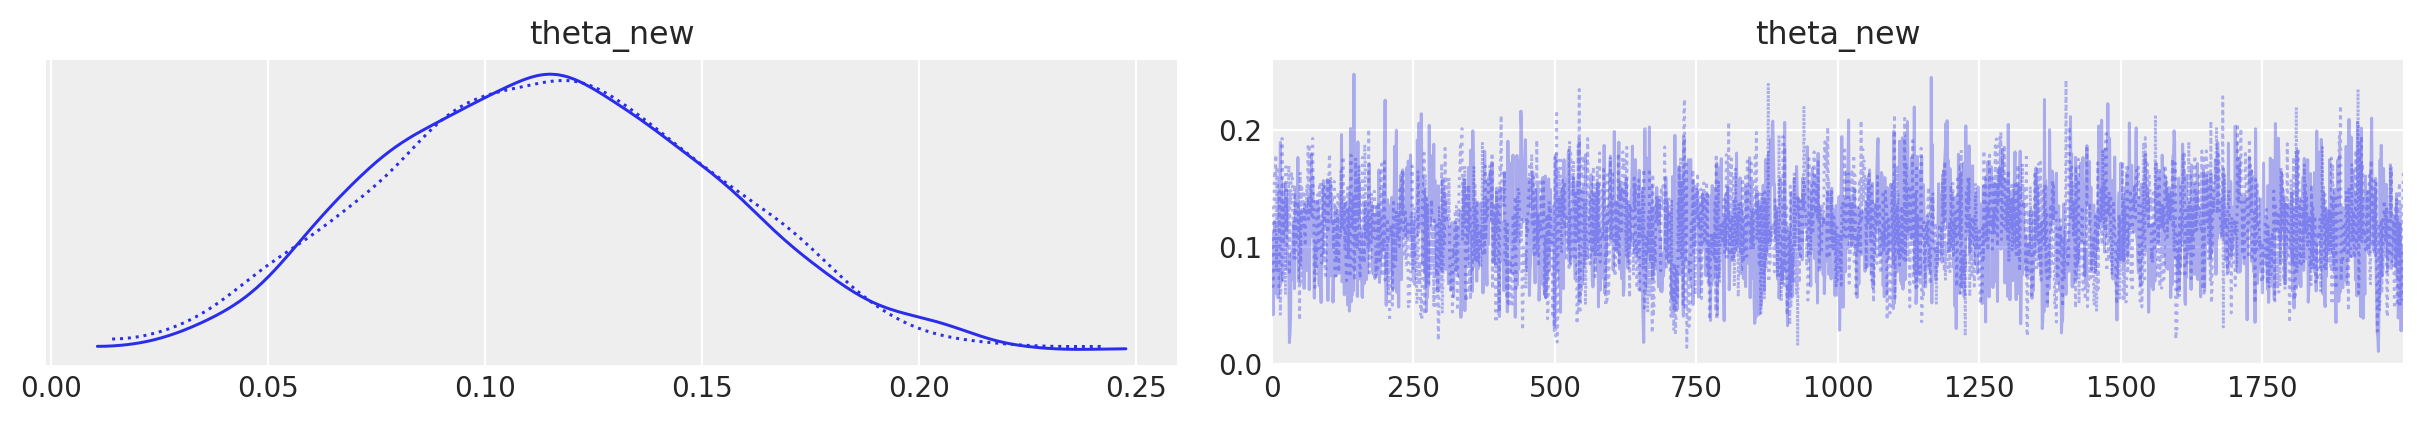

In [22]:
az.plot_trace(trace, var_names=["theta_new"]); # 50 at-bats